# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [38]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

### Define functions

In [39]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [40]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [41]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What do the reference and rating numbers represent? (Hint: read the dataset documentation and write down the interpretation for each number).

In [42]:
# YOUR CODE HERE
# 1
print(df.shape[1], "columns")

9 columns


In [43]:
# 2
print(df.shape[0], "rows")

1795 rows


In [44]:
# 3
print(f"{df.columns = }")

df.columns = Index(['maker', 'specific_origin', 'reference_number', 'review_date',
       'cocoa_percent', 'maker_location', 'rating', 'bean_type',
       'broad_origin'],
      dtype='object')


In [45]:
# 4
df.nunique()

maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64

In [46]:
# 5
""" \
rating is an experts rating of the chocolate bar from 1 to 5. \
reference_number is a value linked to when the review was entered in the database. Higher = more recent. \
"""

' rating is an experts rating of the chocolate bar from 1 to 5. reference_number is a value linked to when the review was entered in the database. Higher = more recent. '

### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you've familiarized yourself with the data a little bit, select a multiclass outcome you're interested in predicting. Note: the outcome should have <span style="color:chocolate">at least 3 classes</span>!

Intuition: conducting a multi-class classification on this chocolate dataset can be incredibly valuable for several reasons: customer preferences and personalization, market analysis, R&D, etc.

`Your answer here:` 

<span style="color:green">
I will predict "broad_origin", but will only consider the top 5 most frequent countries to simplify the task.
</span>

---
### Step 2: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 3:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features within the dataset and the chosen outcome;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

In [47]:
df.info()

df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   maker             1795 non-null   object 
 1   specific_origin   1795 non-null   object 
 2   reference_number  1795 non-null   int64  
 3   review_date       1795 non-null   int64  
 4   cocoa_percent     1795 non-null   float64
 5   maker_location    1795 non-null   object 
 6   rating            1795 non-null   float64
 7   bean_type         1795 non-null   object 
 8   broad_origin      1795 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB


maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64

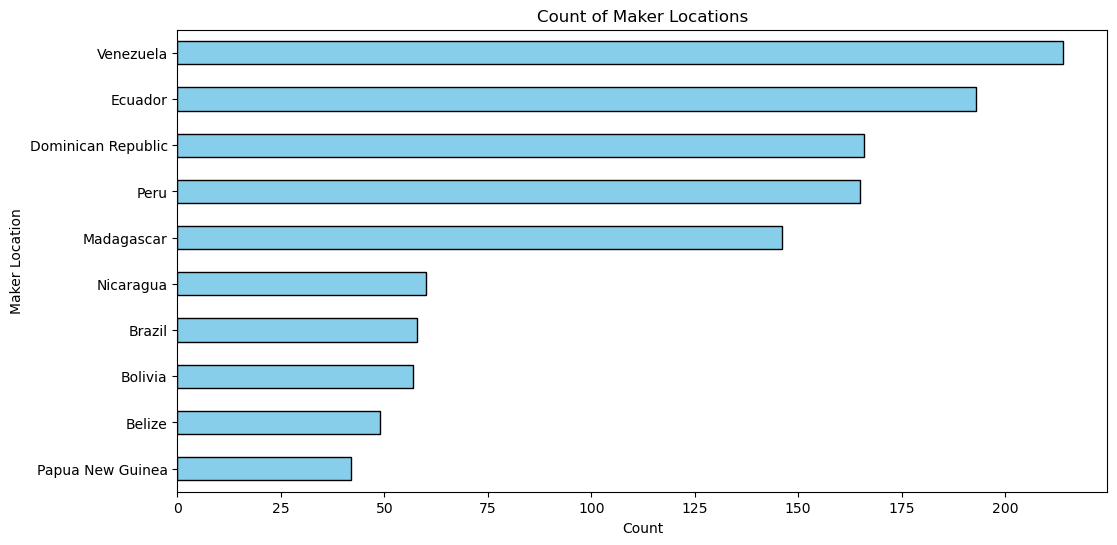

'INSIGHT: there are 58 unique maker_location values, but 5 have much more than the rest. I can focus on these 5 to narrow the scope of my model.'

In [48]:
# plot 1

def plot_feature_values_dist(df, feature, top10 = False) -> None:
    """ plots a horizontal bar chart to show the distribution of values for the specified feature """
    if top10:
        maker_location_counts = df[feature].value_counts()[:10].sort_values()
    else:
        maker_location_counts = df[feature].value_counts().sort_values()

    # Plotting the horizontal bar chart
    plt.figure(figsize=(12, 6))
    maker_location_counts.plot(kind='barh', color='skyblue', edgecolor='black')
    plt.xlabel('Count')
    plt.ylabel('Maker Location')
    plt.title('Count of Maker Locations')
    plt.show()


plot_feature_values_dist(df, 'broad_origin', top10=True)

"""INSIGHT: there are 58 unique maker_location values, but 5 have much more than the rest. I can focus on these 5 to narrow the scope of my model."""

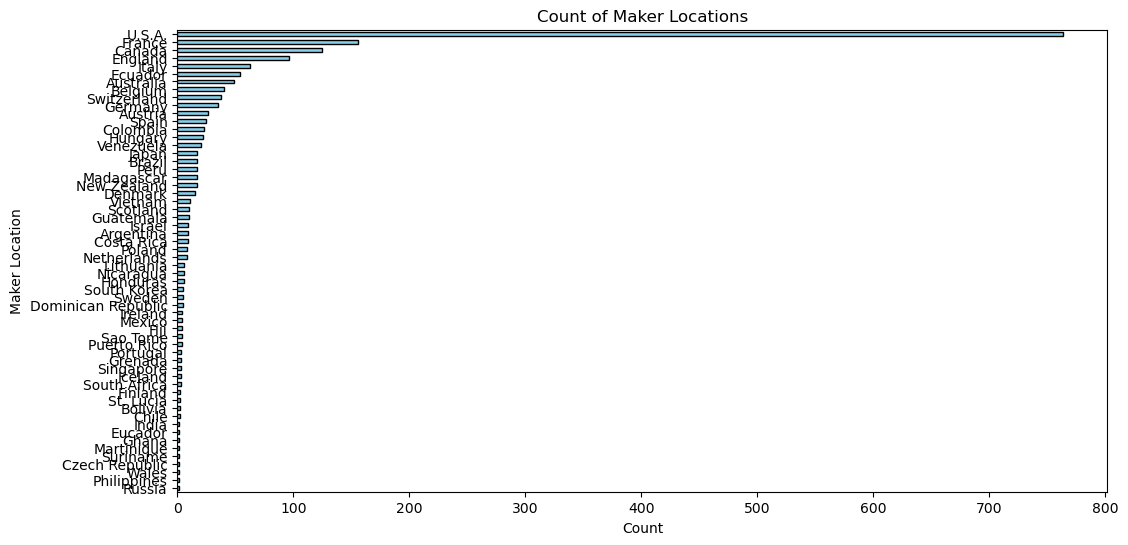

' INSIGHT: the United States makes far more chocolate bars than any other country. '

In [49]:
plot_feature_values_dist(df, 'maker_location')

""" INSIGHT: the United States makes far more chocolate bars than any other country. """

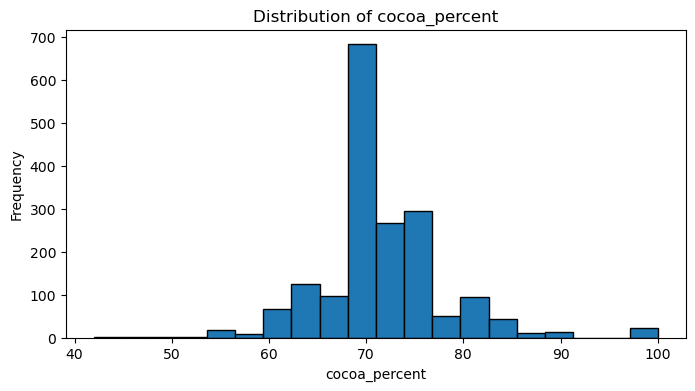

' INSGIHT: cocoa percent is fairly normally distributed, with most around 70% - 75% '

In [50]:
# Plot 2

plt.figure(figsize=(8,4))
plt.hist(df['cocoa_percent'], bins=20, edgecolor='black')
plt.xlabel('cocoa_percent')
plt.ylabel('Frequency')
plt.title('Distribution of cocoa_percent')
plt.show()

""" INSGIHT: cocoa percent is fairly normally distributed, with most around 70% - 75% """

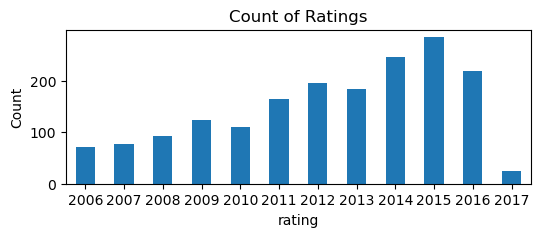

' INSIGHT: very few bars receive a rating below 2.5 and above 4. A perfect 5 star rating seems to be nearly impossible. '

In [51]:
# Plot 3
# Show the counts of each rating value

def make_plot3():
    plt.figure(figsize=(6, 2))
    review_dates = df['review_date'].value_counts().sort_index()
    review_dates.plot(kind='bar')

    plt.xlabel('rating')
    plt.ylabel('Count')
    plt.title('Count of Ratings')
    plt.xticks(rotation=0)
    plt.show()

make_plot3()
""" INSIGHT: very few bars receive a rating below 2.5 and above 4. A perfect 5 star rating seems to be nearly impossible. """

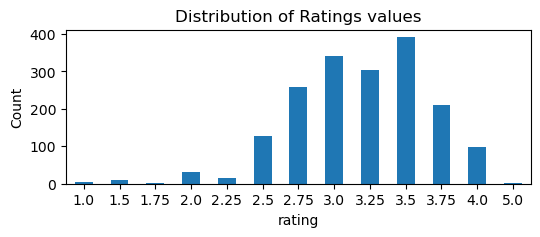

' INSIGHT: very few bars receive a rating below 2.5 and above 4. A perfect 5 star rating seems to be nearly impossible. '

In [52]:
# plot 4
# Calculate the counts of each rating value
def make_plot4():
    plt.figure(figsize=(6, 2))
    rating_counts = df['rating'].value_counts().sort_index()
    rating_counts.plot(kind='bar')

    plt.xlabel('rating')
    plt.ylabel('Count')
    plt.title('Distribution of Ratings values')
    plt.xticks(rotation=0)
    plt.show()

make_plot4()

""" INSIGHT: very few bars receive a rating below 2.5 and above 4. A perfect 5 star rating seems to be nearly impossible. """

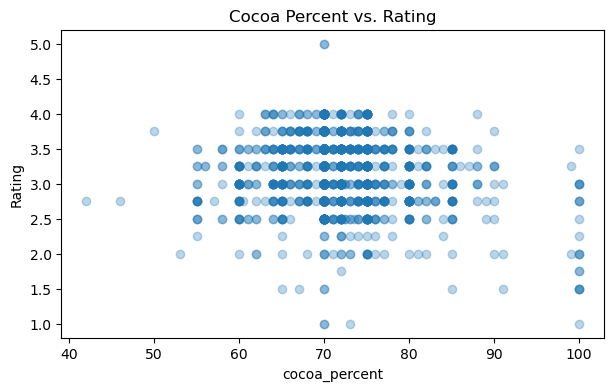

' INSIGHT: there is no obvious linear relationship between the cocoa percent and rating. '

In [53]:
# plot 5
plt.figure(figsize=(7, 4))
plt.scatter(df['cocoa_percent'], df['rating'], alpha=.3)
plt.xlabel('cocoa_percent')
plt.ylabel('Rating')
plt.title('Cocoa Percent vs. Rating')
plt.show()

""" INSIGHT: there is no obvious linear relationship between the cocoa percent and rating. """

---
### Step 3: Data preprocessing

### <span style="color:chocolate">Exercise 4:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Identify the features of interest;
2. Perform necessary cleaning on the features;
3. Reassess the outcome variable if desired (e.g., potentially reducing the number of classes, while ensuring a minimum of 3);
4. Shuffle the dataset;
5. Create training, validation, and test datasets using a 60/20/20 split;
6. Standardize the data;
7. Integrate any supplementary tasks deemed crucial for modeling, especially considering the chosen outcome variable.

In [54]:
# # step 1: filter for only the top 5 most frequent origin countries

def filter_df_top_5(df):
    """ 
        filter the dataframe to only keep rows where broad_origin is one 
        of the top 5 most frequent values. 
    """
    top_5_values = df['broad_origin'].value_counts().nlargest(5).index
    filtered_df = df[df['broad_origin'].isin(top_5_values)]
    return filtered_df

# apply the function
df = filter_df_top_5(df)

# Make sure we only have 5 unique values for broad_origin now
df.broad_origin.value_counts()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   maker             1795 non-null   object 
 1   specific_origin   1795 non-null   object 
 2   reference_number  1795 non-null   int64  
 3   review_date       1795 non-null   int64  
 4   cocoa_percent     1795 non-null   float64
 5   maker_location    1795 non-null   object 
 6   rating            1795 non-null   float64
 7   bean_type         1795 non-null   object 
 8   broad_origin      1795 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB


## process target variable
- Condense outcome categories from 58 maker_location values to 6 maker_continent values


In [59]:
# df['broad_origin'].nunique()
# df['class_labels'] = df['broad_origin'].map(label_encoder)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the 'broad_origin' column
label_encoder.fit_transform(df['broad_origin'])

array([116, 134, 134, ...,  64,  64,  12])

In [19]:
# encode continent name as label numbers
label_encoder = {
    'Venezuela': 0,
    'Ecuador': 1,
    'Dominican Republic': 2,
    'Peru': 3,
    'Madagascar': 4,
}

# create decoder map to flip numbers back to continent names
label_decoder = {value: key for key, value in label_encoder.items()}

df['class_labels'] = df['broad_origin'].map(label_encoder)

# show the resulting values
print(f"{df.class_labels.unique() = }" )

df[['broad_origin', 'class_labels']].value_counts()

df.class_labels.unique() = array([3, 0, 4, 1, 2])


broad_origin        class_labels
Venezuela           0               214
Ecuador             1               193
Dominican Republic  2               166
Peru                3               165
Madagascar          4               146
Name: count, dtype: int64

## `train test split`

In [20]:
import tensorflow as tf
from sklearn.model_selection import train_test_split


features_numerical = ['cocoa_percent', 'rating', 'review_date']
features_categorical = ['bean_type', 'maker_location']
target = 'class_labels'

# Define outcome
y = df[target]

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[features_categorical])

# Combine numerical and encoded categorical features
X = pd.concat([df[features_numerical], df_encoded], axis=1)

# Train / Test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

# Train / Val split
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1, shuffle=True)

print(f"{X_train.shape = }")
print(f"{y_train.shape = }")

print(f"{X_val.shape = }")
print(f"{y_val.shape = }")

print(f"{X_test.shape = }")
print(f"{y_test.shape = }")


2024-06-16 11:47:47.023554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


X_train.shape = (530, 65)
y_train.shape = (530,)
X_val.shape = (177, 65)
y_val.shape = (177,)
X_test.shape = (177, 65)
y_test.shape = (177,)


In [21]:
##############################
# create full train dataframe for EDA in future steps
df_train = pd.concat([y_train, X_train], axis=1)

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 530 entries, 507 to 432
Data columns (total 66 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   class_labels                        530 non-null    int64  
 1   cocoa_percent                       530 non-null    float64
 2   rating                              530 non-null    float64
 3   review_date                         530 non-null    int64  
 4   bean_type_Blend                     530 non-null    bool   
 5   bean_type_Blend-Forastero,Criollo   530 non-null    bool   
 6   bean_type_Criollo                   530 non-null    bool   
 7   bean_type_Criollo (Amarru)          530 non-null    bool   
 8   bean_type_Criollo (Ocumare 61)      530 non-null    bool   
 9   bean_type_Criollo (Ocumare 67)      530 non-null    bool   
 10  bean_type_Criollo (Ocumare 77)      530 non-null    bool   
 11  bean_type_Criollo (Ocumare)         530 non-null

,class_labels,cocoa_percent,rating,review_date,bean_type_Blend,"bean_type_Blend-Forastero,Criollo",bean_type_Criollo,bean_type_Criollo (Amarru),bean_type_Criollo (Ocumare 61),bean_type_Criollo (Ocumare 67),...,maker_location_Puerto Rico,maker_location_Russia,maker_location_Scotland,maker_location_Singapore,maker_location_South Africa,maker_location_Spain,maker_location_Sweden,maker_location_Switzerland,maker_location_U.S.A.,maker_location_Venezuela
507,0,72.00,2.75,2016,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1238,3,65.00,3.00,2012,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1180,2,72.00,2.75,2015,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
561,0,70.00,3.00,2010,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1096,0,70.00,2.75,2014,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## scale and standardize features, label encode target

In [22]:
from sklearn.preprocessing import StandardScaler

# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_val_std = sc_x.fit(X_train).transform(X_val)
X_test_std = sc_x.fit(X_train).transform(X_test)

---
### Step 4: Exploratory data analysis (EDA) - cont'd

### <span style="color:chocolate">Exercise 5:</span> More plots (5 points)

Conduct any further exploratory data analysis (EDA) you believe necessary to validate the successful preprocessing of the data.

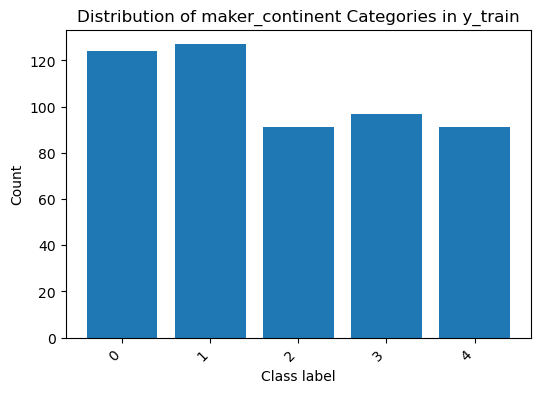

[0 1 2 3 4] [124 127  91  97  91]


{'Venezuela': 0,
 'Ecuador': 1,
 'Dominican Republic': 2,
 'Peru': 3,
 'Madagascar': 4}

In [23]:
# Get the unique classes and their counts
labels, counts = np.unique(df_train.class_labels, return_counts=True)

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.xlabel('Class label')
plt.ylabel('Count')
plt.title('Distribution of maker_continent Categories in y_train')
plt.xticks(rotation=45, ha='right')
plt.show()

print(labels, counts)
label_encoder

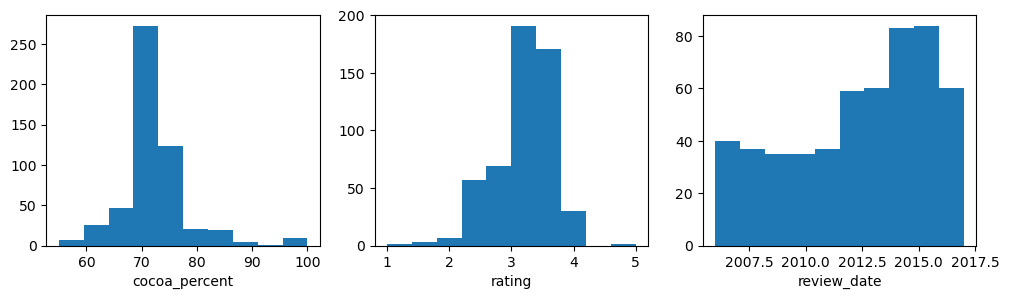

In [24]:
columns = ['cocoa_percent', 'rating', 'review_date']

fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(12,3))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

---
### Step 5: Modeling

### <span style="color:chocolate">Exercise 6:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [25]:
# 1


def get_majority_class_label(y_data):
    """ Returns the most common label value in the specified y_data array. """
    value_counts = np.bincount(y_data)
    return np.argmax(value_counts)


def baseline_classifier(X_data, majority_class = 4, format = 'label') -> np.array:
    """ predict the majority class of 4 with proba = 1, all others with proba = 0 """
    z = 1e-15 # use this instead of 0 to aid the log loss calculation
    output_length = X_data.shape[0]
    baseline_proba_vector = [[z,z,z,z,1,z]] 
    output_vector = np.array(baseline_proba_vector * output_length)

    if format == 'vector': # option to return the probability vector (for log loss calculations)
        return output_vector
    else:   # or, by default, returns the majority class label of 4
        return output_vector.argmax(axis=1) 


def accuracy(y_true, y_pred):
    """ Computes the accuracy metric, calculated as the % of correct predictions . """
    num_correct_preds = np.sum(y_true == y_pred)
    num_total_preds = len(y_true)
    return round(num_correct_preds / num_total_preds, 4)


###################################################
# show the majority class from y_train
majority_class = get_majority_class_label(y_train)
print(f"{majority_class = }, (label = {label_decoder[majority_class]})")

# predict y_train and y_val with baseline model
y_train_pred_baseline = baseline_classifier(X_train, majority_class, format='label')

# compute accuracy
baseline_accuracy = accuracy(y_train, y_train_pred_baseline)
print(F"{baseline_accuracy = :.4f}")

majority_class = 1, (label = Ecuador)
baseline_accuracy = 0.1717


In [26]:
# 2

def my_cross_entropy_loss(y_true, y_pred_probs):
    """ Computes the Log Loss (cross-entropy loss) metric. """
    # one-hot encode the y_true data
    y_true_probs = tf.one_hot(y_true, depth = 6).numpy()

    # clip values to prevent the true zeros from messing it up
    epsilon = 1e-15
    y_pred_probs = np.clip(y_pred_probs, epsilon, 1 - epsilon)

    # calculate the loss
    loss = -np.mean(np.sum(y_true_probs * np.log(y_pred_probs), axis=1))

    # round output value for easier interpretation
    return round(loss, 4)

# create one hot vector for baseline model predictions, then calculate log loss for train and val sets
y_train_pred_probs_baseline = baseline_classifier(X_train, majority_class, format='vector')
print("cross_entropy_loss train:", my_cross_entropy_loss(y_train, y_train_pred_probs_baseline))

y_val_pred_probs_baseline = baseline_classifier(X_val, majority_class, format='vector')
print("cross_entropy_loss val:", my_cross_entropy_loss(y_val, y_val_pred_probs_baseline))

cross_entropy_loss train: 28.6085
cross_entropy_loss val: 29.4653


2024-06-16 11:47:49.538504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-16 11:47:49.538543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### <span style="color:chocolate">Exercise 7:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

### build and compile the model

In [27]:
# 1
import tensorflow as tf
from tensorflow import keras

def build_compile_model(num_features, num_classes, lr = .0001):
    """Return a simple neural network model with one hidden layer using the Keras Sequential API."""
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = (num_features,), name = 'input'),
        tf.keras.layers.Dense(units = num_classes,
                              use_bias = True,
                              activation = 'softmax', 
                              kernel_initializer = keras.initializers.RandomNormal(stddev=0.01),
                              bias_initializer = keras.initializers.RandomNormal(stddev=0.01),
                              name = 'Output'),
    ])
  
    
    # Use Categorical Crossentropy as our loss and the SGD optimizer.
    model.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
        # optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

# Build a model
model_tf = build_compile_model(num_features = X_train.shape[1], num_classes = y_train.nunique(), lr = .0001)
model_tf.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 5)                 330       
                                                                 
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________


# Train model

In [28]:
tf.random.set_seed(1)
np.random.seed(1)

hist = model_tf.fit(
    x = X_train_std, 
    y = y_train,
    validation_data = [X_val_std, y_val],
    batch_size = 32,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
 1/17 [>.............................] - ETA: 4s - loss: 1.6276 - accuracy: 0.0625

2024-06-16 11:47:50.120253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-16 11:47:50.135351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


17/17 [==============================] - 1s 23ms/step - loss: 1.6204 - accuracy: 0.1472 - val_loss: 1.6105 - val_accuracy: 0.1638
Epoch 2/10
12/17 [====================>.........] - ETA: 0s - loss: 1.6169 - accuracy: 0.1641

2024-06-16 11:47:50.543373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 8ms/step - loss: 1.6196 - accuracy: 0.1472 - val_loss: 1.6100 - val_accuracy: 0.1638
Epoch 3/10
17/17 [==============================] - 0s 7ms/step - loss: 1.6189 - accuracy: 0.1472 - val_loss: 1.6094 - val_accuracy: 0.1638
Epoch 4/10
17/17 [==============================] - 0s 7ms/step - loss: 1.6181 - accuracy: 0.1528 - val_loss: 1.6089 - val_accuracy: 0.1695
Epoch 5/10
17/17 [==============================] - 0s 12ms/step - loss: 1.6174 - accuracy: 0.1604 - val_loss: 1.6083 - val_accuracy: 0.1695
Epoch 6/10
17/17 [==============================] - 0s 7ms/step - loss: 1.6166 - accuracy: 0.1642 - val_loss: 1.6078 - val_accuracy: 0.1695
Epoch 7/10
17/17 [==============================] - 0s 7ms/step - loss: 1.6159 - accuracy: 0.1660 - val_loss: 1.6072 - val_accuracy: 0.1864
Epoch 8/10
17/17 [==============================] - 0s 8ms/step - loss: 1.6152 - accuracy: 0.1698 - val_loss: 1.6067 - val_accuracy: 0.1864
Epoch 9/10
17/17 [============

In [29]:
# show an example prediction
y_val_pred_tf1 = model_tf.predict(X_val_std, verbose=0)

y_val_pred_tf1[0], y_val_pred_tf1[0].argmax()

2024-06-16 11:47:51.931525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(array([0.19100408, 0.19931275, 0.20273986, 0.20912315, 0.19782016],
       dtype=float32),
 3)

In [30]:
# Show learned model
w = model_tf.layers[0].get_weights()[0]
b = model_tf.layers[0].get_weights()[1]

print('Bias:', b)
print('Weights', w)

Bias: [-0.01565367  0.00103737 -0.00128806 -0.00139692 -0.00432742]
Weights [[ 2.08177930e-03 -9.54858307e-03 -7.44748255e-03  1.04017032e-03
  -1.04788912e-03]
 [ 1.08079817e-02 -3.73945618e-03 -1.41933709e-02  1.19901670e-03
   2.19686585e-03]
 [-6.59101969e-03 -3.26973177e-03 -6.70411810e-03  1.06475791e-02
   7.16854259e-03]
 [ 5.04357880e-03 -1.41439317e-02 -4.22274228e-03 -1.61862336e-02
   3.58100352e-03]
 [-5.67945233e-03 -3.83409322e-03  4.41613374e-04 -5.58175612e-03
   1.16771432e-02]
 [-6.94754394e-03 -6.89059845e-04  2.01327447e-02 -6.45197462e-03
   3.71987326e-03]
 [ 9.31723451e-04  1.14956805e-02 -6.80244528e-03 -1.95582095e-03
   1.27642020e-03]
 [ 1.51941190e-02  2.33258456e-02 -1.15434332e-02  6.71106158e-03
  -1.26663642e-02]
 [ 1.19858664e-02 -5.45881805e-04  3.67619004e-03 -4.48655244e-03
  -5.42734051e-03]
 [ 1.39781963e-02  3.33988573e-03  1.52755352e-02  4.87453258e-03
  -2.00989627e-04]
 [-1.81990620e-02  3.10637685e-03 -6.61448715e-03  1.78219900e-02
  -7.434

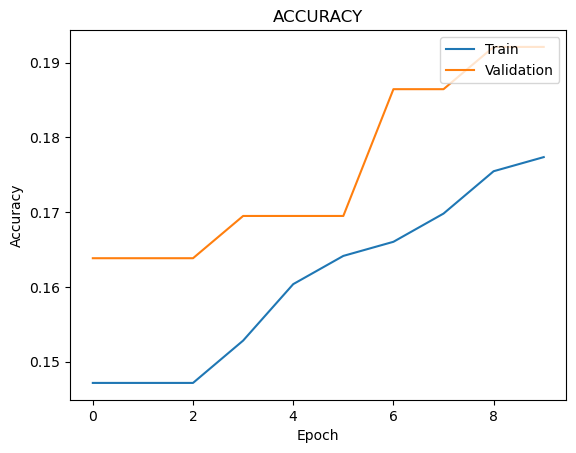

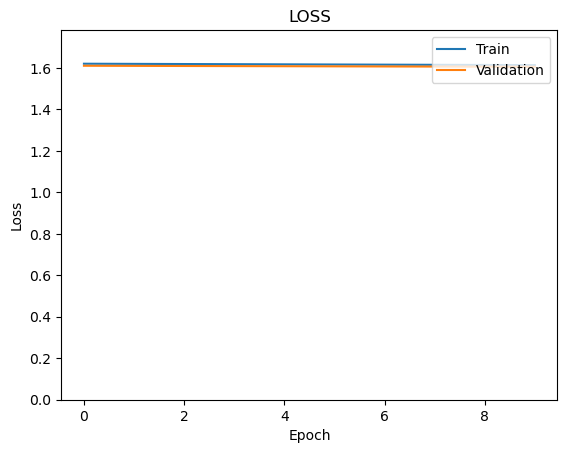

In [31]:
def plot_history(history_object):
    plt.plot(history_object.history['accuracy'])
    plt.plot(history_object.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('LOSS')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0, top = max(history_object.history['val_loss'] + history_object.history['loss'])*1.1)
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

plot_history(hist)

---
### Step 6: Hyperparameter tuning

### <span style="color:chocolate">Exercise 8:</span> Choosing hyperparameters (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

Epoch 1/30
 27/106 [======>.......................] - ETA: 0s - loss: 1.5690 - accuracy: 0.4000

2024-06-16 12:00:35.966079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-16 12:00:35.978232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


104/106 [============================>.] - ETA: 0s - loss: 1.4710 - accuracy: 0.4846

2024-06-16 12:00:36.645583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 1s 8ms/step - loss: 1.4707 - accuracy: 0.4849 - val_loss: 1.3802 - val_accuracy: 0.5028
Epoch 2/30
106/106 [==============================] - 1s 8ms/step - loss: 1.2255 - accuracy: 0.6019 - val_loss: 1.2863 - val_accuracy: 0.5028
Epoch 3/30
106/106 [==============================] - 1s 6ms/step - loss: 1.1121 - accuracy: 0.6057 - val_loss: 1.2483 - val_accuracy: 0.4915
Epoch 4/30
106/106 [==============================] - 1s 9ms/step - loss: 1.0513 - accuracy: 0.6189 - val_loss: 1.2288 - val_accuracy: 0.4972
Epoch 5/30
106/106 [==============================] - 1s 6ms/step - loss: 1.0139 - accuracy: 0.6264 - val_loss: 1.2200 - val_accuracy: 0.5028
Epoch 6/30
106/106 [==============================] - 1s 6ms/step - loss: 0.9896 - accuracy: 0.6189 - val_loss: 1.2163 - val_accuracy: 0.5085
Epoch 7/30
106/106 [==============================] - 1s 7ms/step - loss: 0.9721 - accuracy: 0.6226 - val_loss: 1.2157 - val_accuracy: 0.5141
Epoch 8/30
106/10

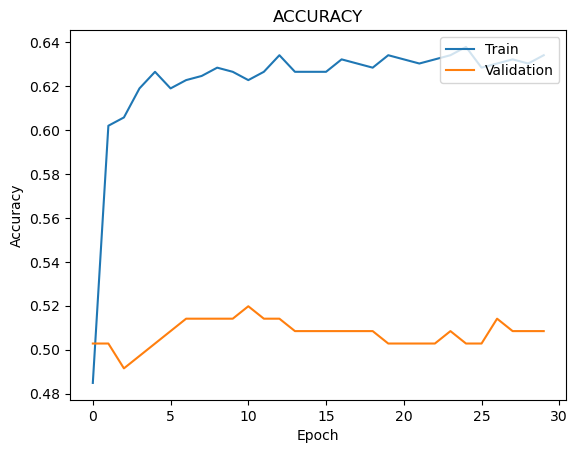

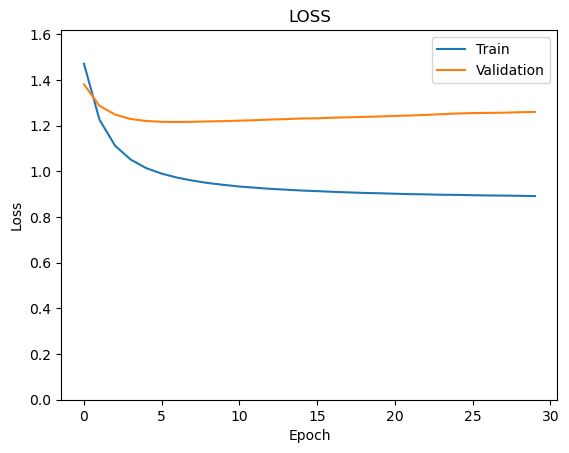

In [59]:
# YOUR CODE HERE

def finetune_model_tf(my_epochs, my_lr, my_batch_size, my_verbose = 1):
    """build and compile model with set params"""
    tf.random.set_seed(1)
    
    model = build_compile_model(num_features = X_train_std.shape[1],
                                num_classes = y_train.nunique(),
                                lr = my_lr)

    hist = model.fit(x = X_train_std, 
                     y = y_train,
                     validation_data = [X_val_std, y_val],
                     batch_size = my_batch_size,
                     epochs = my_epochs,
                     verbose = my_verbose)

    return model, hist

model_tf_tuned, hist_tuned = finetune_model_tf(my_epochs = 30, my_lr = .01, my_batch_size = 5, my_verbose = 1)

plot_history(hist_tuned)

In [55]:
# print predicted vector for training for quality control
y_train_pred_tf = model_tf_tuned.predict(x=X_train_std, verbose=0)
y_train_pred_tf[0]

2024-06-16 11:58:11.651799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([0.15970458, 0.19966097, 0.28213108, 0.21578456, 0.14271885],
      dtype=float32)

---
### Step 7: Evaluation and generalization

### <span style="color:chocolate">Exercise 9:</span> Compute metrics (5 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [53]:
# YOUR CODE HERE

def predict_labels(model, X_data):
    y_predictions = model.predict(X_data, verbose=0)
    return np.argmax(y_predictions, axis=1)

y_train_pred_labels = predict_labels(model_tf_tuned, X_train_std)
print("train accuracy =", accuracy(y_train, y_train_pred_labels))

y_test_pred_labels = predict_labels(model_tf_tuned, X_test_std)
print("test accuracy =", accuracy(y_test, y_test_pred_labels))


""" INSIGHTS: the model shows fair generalization ability. The test accuracy is lower \
than the train accuracy, which suggests the model may be overfit, but it still performs \
much better than the baseline model accuracy of 0.1849 """

train accuracy = 0.1717
test accuracy = 0.1525


' INSIGHTS: the model shows fair generalization ability. The test accuracy is lower than the train accuracy, which suggests the model may be overfit, but it still performs much better than the baseline model accuracy of 0.1849 '

### <span style="color:chocolate">Exercise 10:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

In [35]:
# YOUR CODE HERE
# plot confusion matrix for test data


[[20  8  9  2  5]
 [ 0 20 10  2  1]
 [ 5  4 25  2  2]
 [ 5  3 11 14  0]
 [ 6  1  1  0 21]]


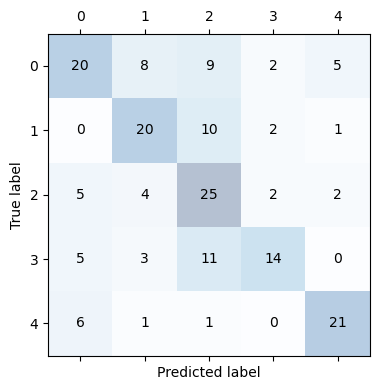

In [36]:
def confusion_matrix_plot(cm):
    """ Confusion matrix matplotlib plot
    param conf_matrix: nested list of TP, TN, FP, FN
    return: None
    """
    fig, ax = plt.subplots(figsize=(4,4))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

conf_matrix = tf.math.confusion_matrix(y_test, y_test_pred_labels).numpy()
print(conf_matrix)

confusion_matrix_plot(conf_matrix)

In [37]:
# 2

def calculate_precisions(cm, decoder):
    num_classes = cm.shape[0]

    # Initialize arrays to store precision and false positives
    precisions = np.zeros(num_classes)
    recalls = np.zeros(num_classes)
    false_positives = np.zeros(num_classes)
    false_negatives = np.zeros(num_classes)

    # Calculate precision and false positives for each predicted class
    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[i, :]) - TP
        FN = np.sum(cm[:, i]) - TP
        precisions[i] = TP / (TP + FP) #if (TP + FP) > 0 else 0
        recalls[i] = TP / (TP + FN) #if (TP + FN) > 0 else 0
        false_positives[i] = FP
        false_negatives[i] = FN

    lowest_precision_class = np.argmin(precisions)
    lowest_precision_value = precisions[lowest_precision_class]
    print(f"Class with lowest precision: {lowest_precision_class} ({decoder[lowest_precision_class]}) -> {lowest_precision_value:.3f}")

    lowest_recall_class = np.argmin(recalls)
    lowest_recall_value = recalls[lowest_recall_class]
    print(f"Class with lowest recall: {lowest_recall_class} ({decoder[lowest_recall_class]}) -> {lowest_recall_value:.3f}")

    largest_fp_class = np.argmax(false_positives)
    largest_fp_value = false_positives[largest_fp_class]
    print(f"Class with the most false positives: {largest_fp_class} with {largest_fp_value}")

    largest_fn_class = np.argmax(false_negatives)
    largest_fn_value = false_negatives[largest_fn_class]
    print(f"Class with the most false negatives: {largest_fn_class} with {largest_fn_value}")

calculate_precisions(conf_matrix, label_decoder)

Class with lowest precision: 3 (Peru) -> 0.424
Class with lowest recall: 2 (Dominican Republic) -> 0.446
Class with the most false positives: 0 with 24.0
Class with the most false negatives: 2 with 31.0


----
### <span style="color:chocolate">Bonus question</span> (20 points)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [38]:
# YOUR CODE HERE